In [1]:
import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import Sobol
import torch
from tqdm.notebook import tqdm

from gekko import GEKKO
from jtoolbox.logger import H5Logger
from sekf.modeling import AbstractNN

from TCLab import *
%matplotlib inline

In [2]:
run_1 = {
    "begin_time": datetime.datetime(2025, 4, 15, 17, 5, 35),
    "begin_n": 2077,
    "end_time": datetime.datetime(2025, 4, 15, 17, 17, 45),
    "end_n": 3111,
    "job_number": 2328309,
}
run_2 = {
    "begin_time": datetime.datetime(2025, 4, 15, 19, 23, 34),
    "begin_n": 3111,
    "end_time": datetime.datetime(2025, 4, 16, 5, 23, 49),
    "end_n": 35405,
    "job_number": 2328521,
}
run_3 = {
    "begin_time": datetime.datetime(2025, 4, 16, 8, 46, 39),
    "begin_n": 58522,
    "end_time": datetime.datetime(2025, 4, 16, 10, 2, 46),
    "end_n": 65536,
    "job_number": 2328994,
}
run = run_1
tps1 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
run = run_2
tps2 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
run = run_3
tps3 = (run["end_time"] - run["begin_time"]).total_seconds() / (run["end_n"] - run["begin_n"])
print(f"tps1: {tps1}, tps2: {tps2}, tps3: {tps3}")

tps1: 0.7059961315280464, tps2: 1.1152226419768378, tps3: 0.6511263187909895


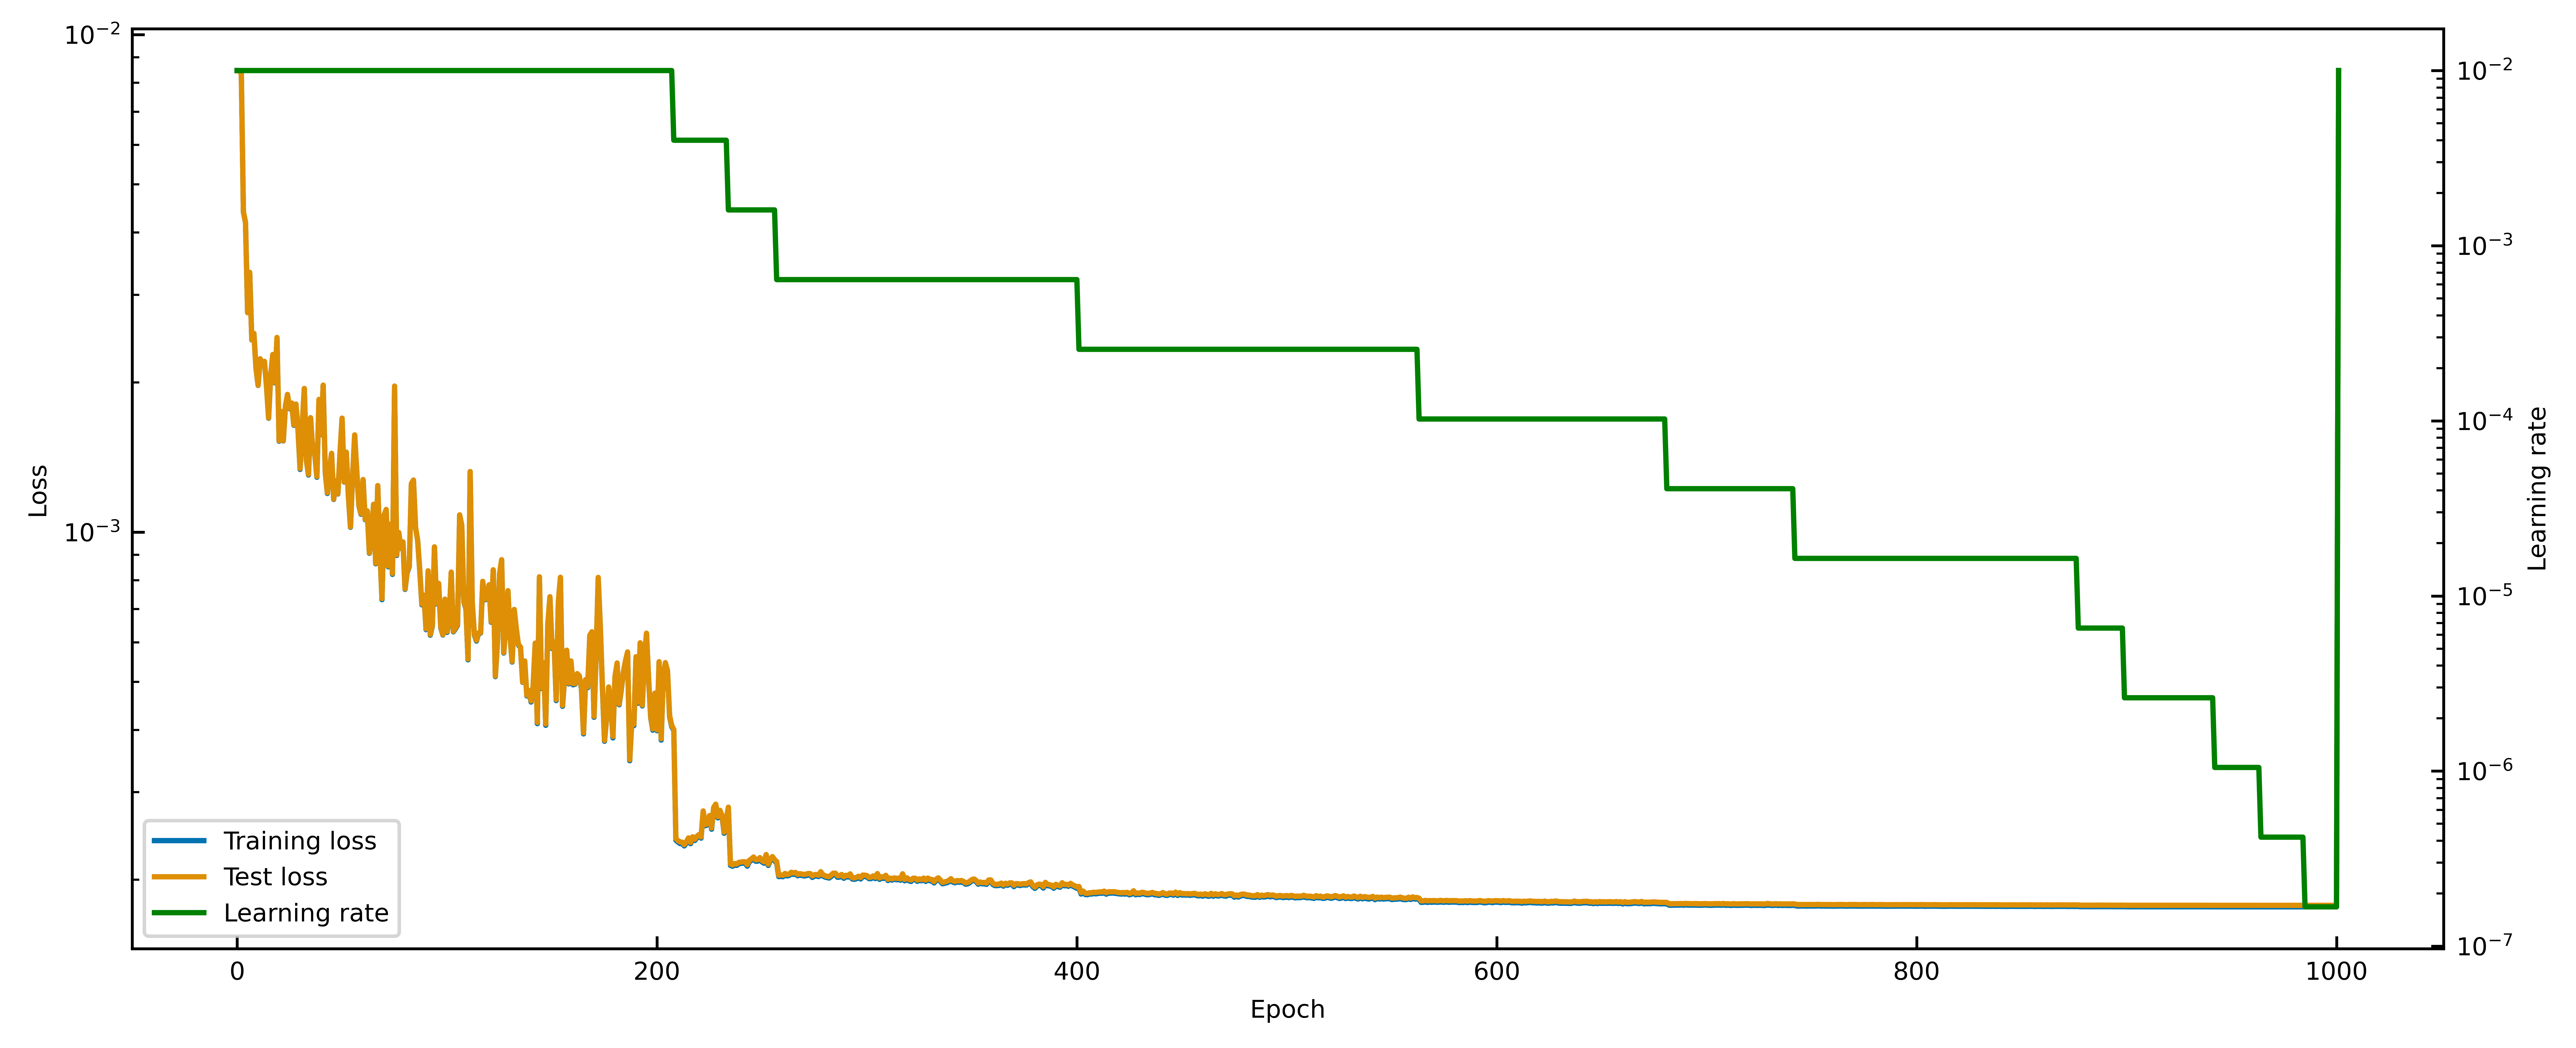

In [3]:
train_dataset = TCLabDataset(logger, prefix="data/train/")
test_dataset = TCLabDataset(logger, prefix="data/test/")

training_losses = logger.get_dataset("training/v0/loss/train")
test_losses = logger.get_dataset("training/v0/loss/test")
learning_rates = logger.get_dataset("training/v0/lr")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
(l1,) = ax.plot(training_losses, label="Training loss")
(l2,) = ax.plot(test_losses, label="Test loss")
ax.set_yscale("log")
ax2 = ax.twinx()
(l3,) = ax2.plot(learning_rates, label="Learning rate", color="green")
ax2.set_yscale("log")

ax.legend(handles=[l1, l2, l3])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax2.set_ylabel("Learning rate")
plt.show()

In [6]:
# TODO: would be nice to plot the simulated outcomes of the optimal / model outputs

NN = torch.load("TCLab_NNv0.pt", weights_only=False)

t10, t20, t1sp, t2sp, q1, q2 = test_dataset.__getitem__(2)
# t10, t20, t1sp, t2sp, q1, q2 = train_dataset.__getitem__(0)
q1_p, q2_p = NN(t10, t20, t1sp, t2sp)
q1_p = q1_p.detach().numpy()
q2_p = q2_p.detach().numpy()

t10 = test_dataset._Tunscale(t10).numpy()
t20 = test_dataset._Tunscale(t20).numpy()
t1sp = test_dataset._Tunscale(t1sp).numpy()
t2sp = test_dataset._Tunscale(t2sp).numpy()
q1 = test_dataset._Qunscale(q1).numpy()
q2 = test_dataset._Qunscale(q2).numpy()
q1_p = test_dataset._Qunscale(q1_p)
q2_p = test_dataset._Qunscale(q2_p)

t = np.linspace(0, 30, 61)

t1_sim_mpc, t2_sim_mpc = tclab_sim(t10, t20, q1, q2)
t1_sim_nn, t2_sim_nn = tclab_sim(t10, t20, q1_p, q2_p)


In [7]:
with plt.rc_context(
    {
        "font.size": 14,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].scatter(0, t10, color="r", marker="o", label=r"$T_1^0$")
    ax[0].scatter(0, t20, color="b", marker="o", label=r"$T_2^0$")
    ax[0].step(t, t1sp, "r--", where="mid", label=r"$T_1^{sp}$")
    ax[0].step(t, t2sp, "b--", where="mid", label=r"$T_2^{sp}$")
    ax[0].plot(t, t1_sim_mpc, "r-", label=r"$T_1^{sim}$ (MPC)")
    ax[0].plot(t, t2_sim_mpc, "b-", label=r"$T_2^{sim}$ (MPC)")
    ax[0].scatter(t, t1_sim_nn, edgecolor="r", facecolor="none", label=r"$T_1^{sim}$ (NN)")
    ax[0].scatter(t, t2_sim_nn, edgecolor="b", facecolor="none", label=r"$T_2^{sim}$ (NN)")
    ax[0].set_ylim(20, 47)
    ax[0].set_xticks(np.arange(0, 30 + 1, 5))
    ax[0].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
    ax[0].legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1.01), edgecolor="none")
    ax[0].set_ylabel("Temperature (°C)")

    ax[1].step(t, q1, "r-", where="mid", label=r"$Q_1$ (MPC)")
    ax[1].step(t, q2, "b-", where="mid", label=r"$Q_2$ (MPC)")
    ax[1].scatter(t, q1_p, edgecolor="r", facecolor="none", label=r"$Q_1$ (NN)")
    ax[1].scatter(t, q2_p, edgecolor="b", facecolor="none", label=r"$Q_2$ (NN)")
    ax[1].set_ylim(-1, 101)
    ax[1].set_xticks(np.arange(0, 30 + 1, 5))
    ax[1].set_xticks(np.arange(0, 30 + 1, 0.5), minor=True)
    ax[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, 1.01), edgecolor="none")
    ax[1].set_ylabel("Heater Power (%)")
    ax[1].set_xlabel("Time (minutes)")

    fig.savefig("fig.png")

/tmp/ipykernel_2538211/1110289107.py:66: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(TC1.value), np.array(TC2.value)


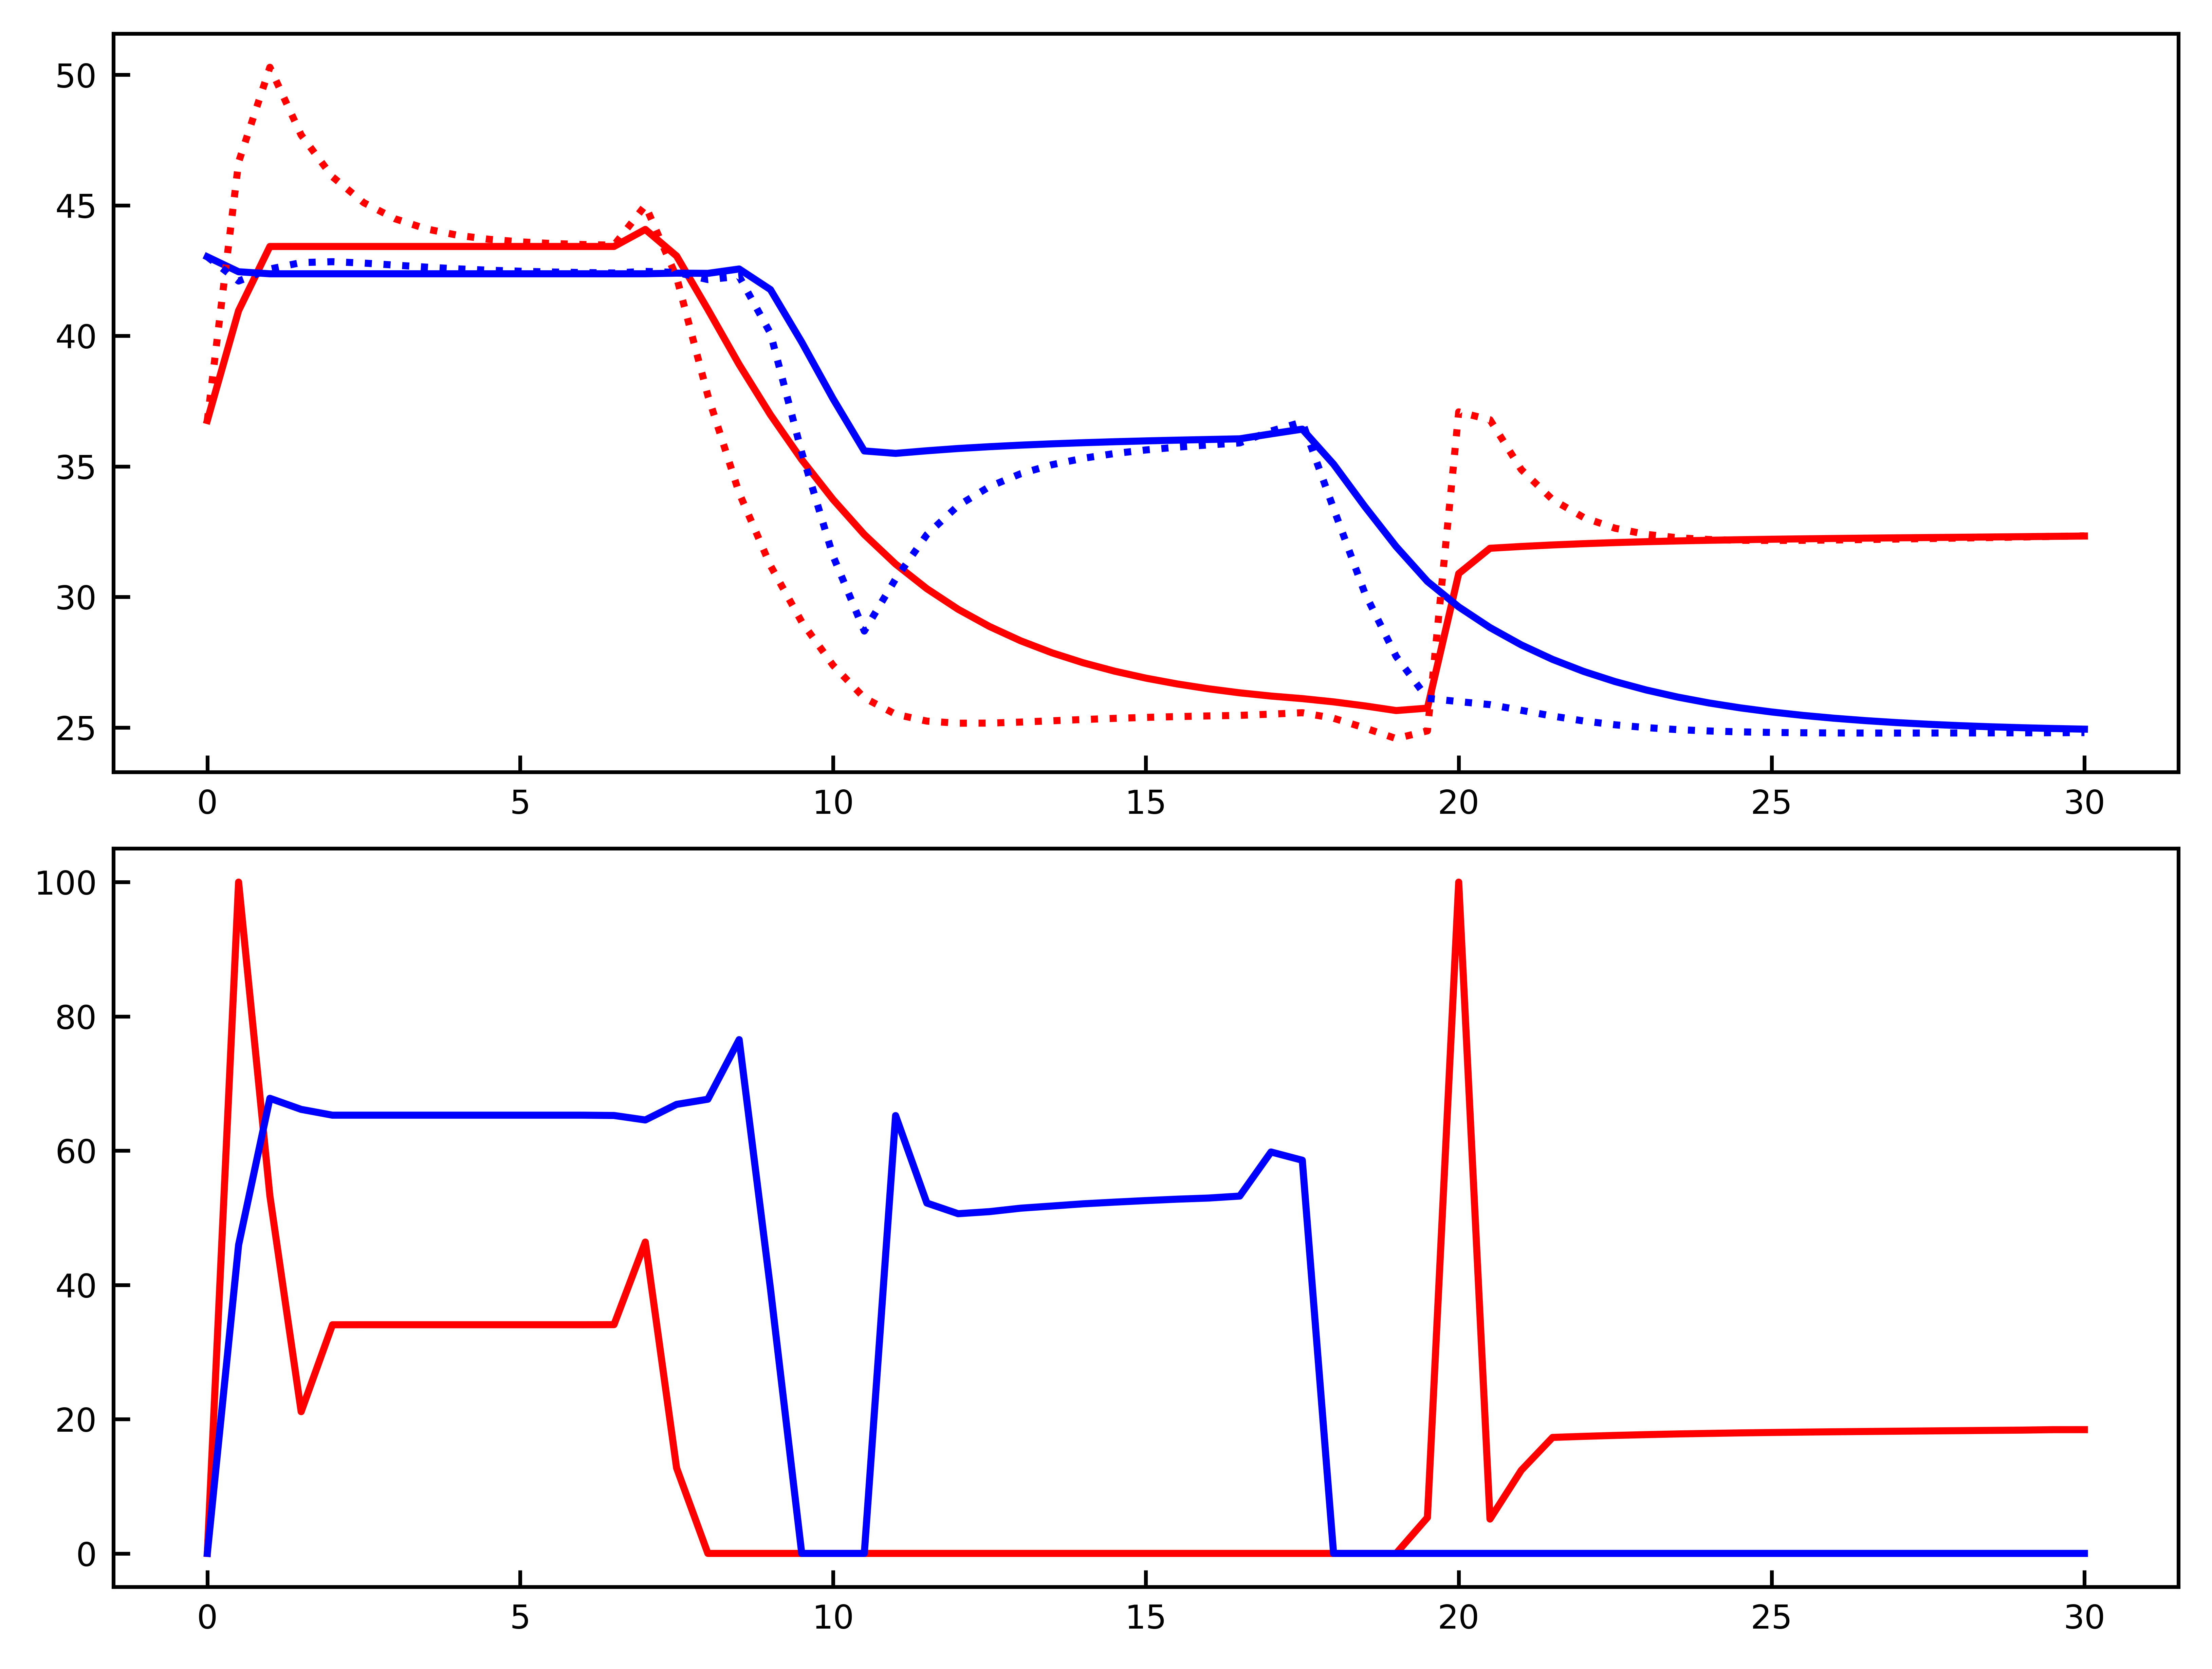

In [15]:
def tclab_sim(t10, t20, q1, q2, **kwargs):
    ### Simulate
    # MPC Prediction
    tf_min = 30  # time in minutes
    tf = tf_min * 60  # (sec)
    n = tf_min * 2 + 1  # one point every 5 seconds

    #########################################################
    # Initialize Model
    #########################################################
    m = GEKKO(remote=True)

    # with a local server
    # m = GEKKO(name='tclab-mpc',server='http://127.0.0.1',remote=True)

    m.time = np.linspace(0, tf, n)  # time points for simulation

    # Parameters from Estimation
    K1 = m.FV(value=kwargs.get("k1", 0.607))
    K2 = m.FV(value=kwargs.get("k2", 0.293))
    K3 = m.FV(value=kwargs.get("k3", 0.24))
    tau12 = m.FV(value=kwargs.get("tau12", 192))
    tau3 = m.FV(value=kwargs.get("tau3", 15))

    # don't update parameters with optimizer
    # K1.STATUS = 0
    # K2.STATUS = 0
    # K3.STATUS = 0
    # tau12.STATUS = 0
    # tau3.STATUS = 0

    # heater setting
    Q1 = m.Param(name="Q1")
    Q1.value = q1
    Q2 = m.Param(name="Q2")
    Q2.value = q2

    # State variables
    # TH1 = m.Var(value=t10, name="th1")  # use Var to initialize with T1m[0]
    TH1 = m.Var(name="th1")
    TH1.value = t10
    # TH2 = m.Var(value=t20, name="th2")  # use Var to initialize with T2m[0])
    TH2 = m.Var(name="th2")
    TH2.value = t20
    # TC1 = m.Var(value=t10, name="tc1")  # use Var to initialize with T1m[0]
    TC1 = m.Var(name="tc1")
    TC1.value = t10
    # TC2 = m.Var(value=t20, name="tc2")  # use Var to initialize with T2m[0]
    TC2 = m.Var(name="tc2")
    TC2.value = t20
    Ta = m.Param(value=23.0)  # degC

    # Heat transfer between two heaters
    DT = m.Intermediate(TH2 - TH1)

    # Empirical correlations
    m.Equation(tau12 * TH1.dt() + (TH1 - Ta) == K1 * Q1 + K3 * DT)
    m.Equation(tau12 * TH2.dt() + (TH2 - Ta) == K2 * Q2 - K3 * DT)
    m.Equation(tau3 * TC1.dt() + TC1 == TH1)
    m.Equation(tau3 * TC2.dt() + TC2 == TH2)
    m.options.IMODE = 4  # simulataneous simulation
    m.solve(disp=False)

    m.cleanup()

    return np.array(TC1.value), np.array(TC2.value)

t10, t20, t1sp, t2sp, q1, q2 = test_dataset.__getitem__(2)

t10 = test_dataset._Tunscale(t10).numpy()
t20 = test_dataset._Tunscale(t20).numpy()
t1sp = test_dataset._Tunscale(t1sp).numpy()
t2sp = test_dataset._Tunscale(t2sp).numpy()
q1 = test_dataset._Qunscale(q1).numpy()
q2 = test_dataset._Qunscale(q2).numpy()

tc1_sys1, tc2_sys1 = tclab_sim(t10, t20, q1, q2)
tc1_sys2, tc2_sys2 = tclab_sim(t10, t20, q1, q2, tau12=60)

fig, ax = plt.subplots(2,1)

ax[0].plot(t, tc1_sys1, "r-")
ax[0].plot(t, tc2_sys1, "b-")
ax[0].plot(t, tc1_sys2, "r:")
ax[0].plot(t, tc2_sys2, "b:")

ax[1].plot(t, q1, "r-")
ax[1].plot(t, q2, "b-")